In [49]:
import os
import pandas as pd
import numpy as np
import mysql.connector
from dotenv import load_dotenv
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import tukey_hsd
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [20]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [21]:
# DB 연결
load_dotenv()

conn = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database="suwon_business"
)

cursor = conn.cursor()

In [22]:
# 쿼리 정의
query = """
SELECT
    t.transaction_date,
    t.district_code,
    d.name AS district_name,
    t.time_block_code,
    t.gender,
    t.age_group_code,
    t.day_of_week,
    t.transaction_amount,
    t.transaction_count,
    w.avg_temp,
    w.max_temp,
    w.min_temp
FROM card_transaction t
JOIN district d ON t.district_code = d.district_id
JOIN weather w ON t.transaction_date = w.weather_date AND t.district_code = w.district_id
"""

df = pd.read_sql(query, conn)
conn.close()

df

/var/folders/36/pdpmp_4s2wv687klck6zglrm0000gn/T/ipykernel_44763/260202010.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,transaction_date,district_code,district_name,time_block_code,gender,age_group_code,day_of_week,transaction_amount,transaction_count,avg_temp,max_temp,min_temp
0,2024-08-01,41111,장안구,1,F,3,4,19556,3,29.2290,33.5963,24.861700
1,2024-08-01,41111,장안구,1,M,2,4,4010,2,29.2290,33.5963,24.861700
2,2024-08-01,41111,장안구,1,M,3,4,14393,3,29.2290,33.5963,24.861700
3,2024-08-01,41111,장안구,1,M,4,4,876,2,29.2290,33.5963,24.861700
4,2024-08-01,41111,장안구,1,M,5,4,939,2,29.2290,33.5963,24.861700
...,...,...,...,...,...,...,...,...,...,...,...,...
1603317,2025-03-31,41117,영통구,10,F,4,1,17503,2,8.0829,15.6633,0.502481
1603318,2025-03-31,41117,영통구,10,F,6,1,102472,2,8.0829,15.6633,0.502481
1603319,2025-03-31,41117,영통구,10,M,3,1,3442,2,8.0829,15.6633,0.502481
1603320,2025-03-31,41117,영통구,10,M,5,1,135210,3,8.0829,15.6633,0.502481


In [23]:
df.columns

Index(['transaction_date', 'district_code', 'district_name', 'time_block_code',
       'gender', 'age_group_code', 'day_of_week', 'transaction_amount',
       'transaction_count', 'avg_temp', 'max_temp', 'min_temp'],
      dtype='object')

In [24]:
df.count()

transaction_date      1603322
district_code         1603322
district_name         1603322
time_block_code       1603322
gender                1603322
age_group_code        1603322
day_of_week           1603322
transaction_amount    1603322
transaction_count     1603322
avg_temp              1603322
max_temp              1603322
min_temp              1603322
dtype: int64

In [25]:
df.info

<bound method DataFrame.info of         transaction_date  district_code district_name  time_block_code gender  \
0             2024-08-01          41111           장안구                1      F   
1             2024-08-01          41111           장안구                1      M   
2             2024-08-01          41111           장안구                1      M   
3             2024-08-01          41111           장안구                1      M   
4             2024-08-01          41111           장안구                1      M   
...                  ...            ...           ...              ...    ...   
1603317       2025-03-31          41117           영통구               10      F   
1603318       2025-03-31          41117           영통구               10      F   
1603319       2025-03-31          41117           영통구               10      M   
1603320       2025-03-31          41117           영통구               10      M   
1603321       2025-03-31          41117           영통구               10      M

In [26]:
df.isnull().mean().sort_values(ascending=False)

transaction_date      0.0
district_code         0.0
district_name         0.0
time_block_code       0.0
gender                0.0
age_group_code        0.0
day_of_week           0.0
transaction_amount    0.0
transaction_count     0.0
avg_temp              0.0
max_temp              0.0
min_temp              0.0
dtype: float64

In [27]:
df.describe()

,district_code,time_block_code,age_group_code,day_of_week,transaction_amount,transaction_count,avg_temp,max_temp,min_temp
count,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06
mean,4.111411e+04,5.464615e+00,5.050107e+00,3.999974e+00,1.773111e+05,1.976734e+01,1.407041e+01,1.897826e+01,9.162558e+00
std,2.268238e+00,2.490763e+00,1.803883e+00,1.995954e+00,4.587060e+05,3.464352e+01,1.073996e+01,1.081094e+01,1.092608e+01
min,4.111100e+04,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,-1.024200e+01,-7.687200e+00,-1.353520e+01
25%,4.111300e+04,3.000000e+00,4.000000e+00,2.000000e+00,1.595700e+04,3.000000e+00,3.514100e+00,8.685690e+00,-1.174090e+00
50%,4.111500e+04,5.000000e+00,5.000000e+00,4.000000e+00,5.194000e+04,8.000000e+00,1.584370e+01,2.152600e+01,9.902900e+00
75%,4.111700e+04,8.000000e+00,6.000000e+00,6.000000e+00,1.595068e+05,2.000000e+01,2.359820e+01,2.786330e+01,1.917180e+01
max,4.111700e+04,1.000000e+01,1.100000e+01,7.000000e+00,5.460398e+07,1.009000e+03,3.020880e+01,3.512770e+01,2.625530e+01


In [28]:
df.shape

(1603322, 12)

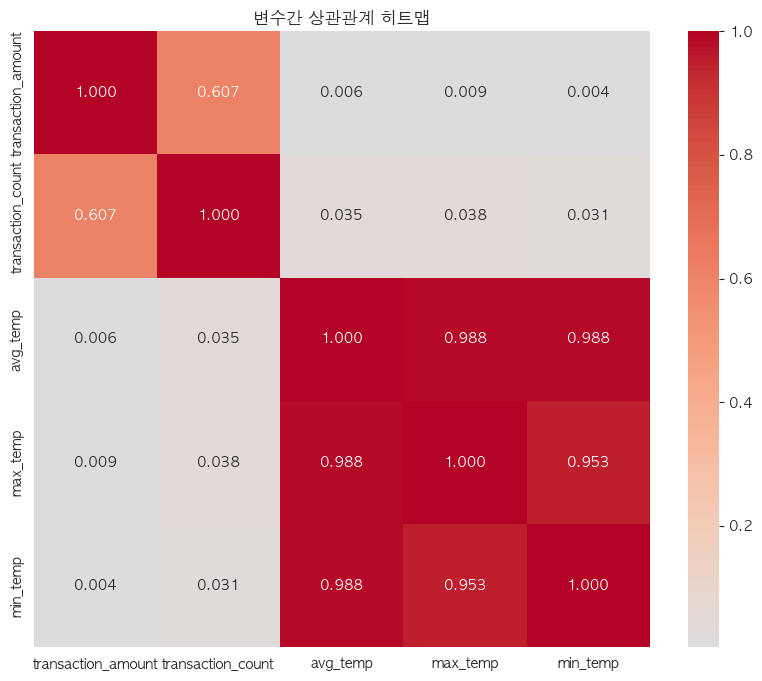

📈 통계적 유의성 검정
평균기온-매출 상관계수: 0.0064 (p-value: 0.000000)
평균기온-거래건수 상관계수: 0.0351 (p-value: 0.000000)



In [29]:
# 상관계수 계산
correlation_vars = ['transaction_amount', 'transaction_count', 'avg_temp', 'max_temp', 'min_temp']
correlation_matrix = df[correlation_vars].corr()

# 상관계수 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('변수간 상관관계 히트맵')
plt.show()


# 통계적 유의성 검정
print("📈 통계적 유의성 검정")
temp_amount_corr, temp_amount_p = stats.pearsonr(df['avg_temp'], df['transaction_amount'])
print(f"평균기온-매출 상관계수: {temp_amount_corr:.4f} (p-value: {temp_amount_p:.6f})")

temp_count_corr, temp_count_p = stats.pearsonr(df['avg_temp'], df['transaction_count'])
print(f"평균기온-거래건수 상관계수: {temp_count_corr:.4f} (p-value: {temp_count_p:.6f})")
print()

In [30]:
# 통계적 유의성 검정
print("📈 통계적 유의성 검정")
temp_amount_corr, temp_amount_p = stats.pearsonr(df['avg_temp'], df['transaction_amount'])
print(f"평균기온-매출 상관계수: {temp_amount_corr:.4f} (p-value: {temp_amount_p:.6f})")

temp_count_corr, temp_count_p = stats.pearsonr(df['avg_temp'], df['transaction_count'])
print(f"평균기온-거래건수 상관계수: {temp_count_corr:.4f} (p-value: {temp_count_p:.6f})")
print()

📈 통계적 유의성 검정
평균기온-매출 상관계수: 0.0064 (p-value: 0.000000)
평균기온-거래건수 상관계수: 0.0351 (p-value: 0.000000)



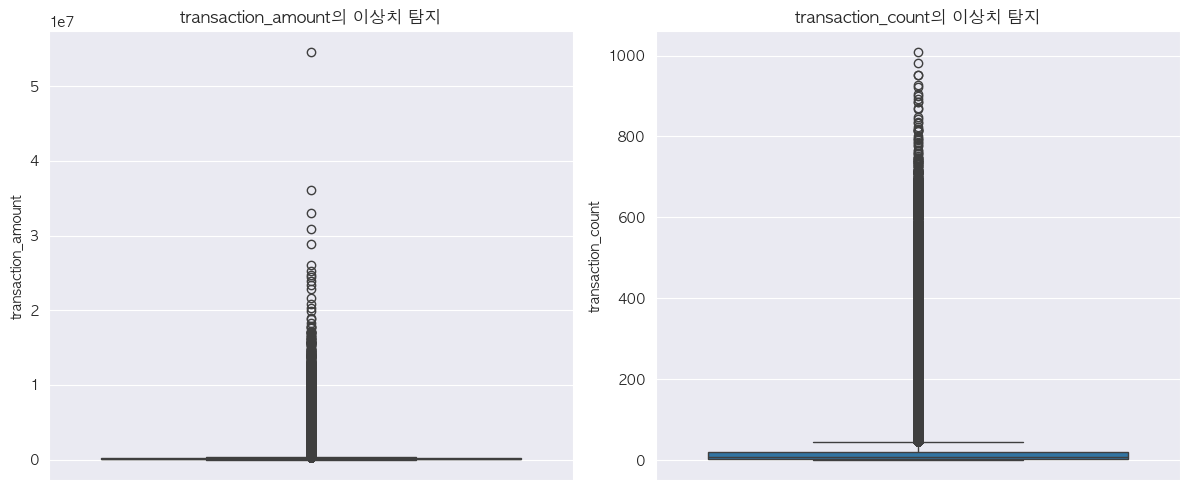

In [31]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(['transaction_amount', 'transaction_count']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'{col}의 이상치 탐지')
plt.tight_layout()
plt.show()

In [32]:
def remove_outliers_iqr(df, columns):
    mask = pd.Series([True] * len(df))
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask &= df[col].between(lower_bound, upper_bound)
    return df[mask]

In [33]:
target_cols = ['transaction_amount', 'transaction_count']

# 이상치 제거된 데이터프레임 생성
df_no_outliers = remove_outliers_iqr(df, target_cols)

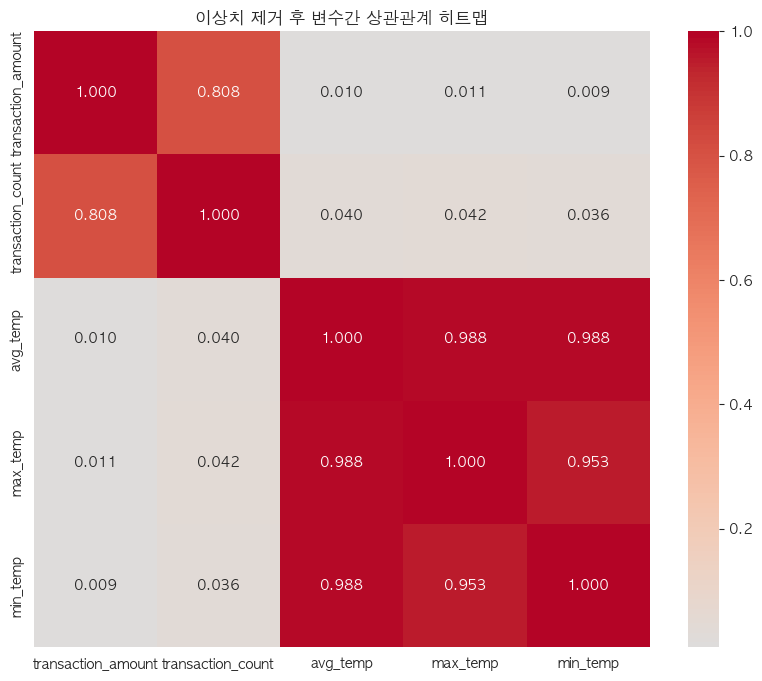

In [36]:
correlation_vars = ['transaction_amount', 'transaction_count',
                    'avg_temp', 'max_temp', 'min_temp']

# 상관계수 계산
correlation_matrix = df_no_outliers[correlation_vars].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('이상치 제거 후 변수간 상관관계 히트맵')
plt.show()

In [37]:
df.groupby('day_of_week')['transaction_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
1,230486.0,149324.463061,376978.947870,78.0,14862.00,46413.5,140346.25,36056981.0
2,226344.0,152953.161648,363667.786231,0.0,15235.75,48032.5,144795.00,30926732.0
3,227411.0,166518.077138,447447.609970,47.0,15629.00,50063.0,151627.00,54603977.0
4,228312.0,159682.488485,392710.464240,14.0,15488.00,49110.5,148373.00,33031231.0
5,233617.0,170925.519829,395002.485975,47.0,16525.00,53159.0,161364.00,23394538.0
6,233557.0,230450.491255,591265.036788,94.0,18461.00,63406.0,197231.00,17697419.0
7,223595.0,210960.372965,577198.120049,94.0,16389.00,56300.0,178911.50,20785693.0


## 요일(X:day_of_week)에 따른 평균 커피 매출(y: amt) 은 영향이 없다.

In [74]:
print("=== 요일별 매출 현황 ===")
daily_stats = df.groupby('day_of_week')['transaction_amount'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
])
print(daily_stats)

# 실질적 차이 크기
daily_mean = df.groupby('day_of_week')['transaction_amount'].mean()
print(f"\n최고 vs 최저 매출 차이: {daily_mean.max() - daily_mean.min():,.0f}원")
print(f"상대적 차이: {(daily_mean.max() / daily_mean.min() - 1) * 100:.1f}%")

=== 요일별 매출 현황 ===
              count           mean   median            std  min       max
day_of_week                                                              
1            230486  149324.463061  46413.5  376978.947870   78  36056981
2            226344  152953.161648  48032.5  363667.786231    0  30926732
3            227411  166518.077138  50063.0  447447.609970   47  54603977
4            228312  159682.488485  49110.5  392710.464240   14  33031231
5            233617  170925.519829  53159.0  395002.485975   47  23394538
6            233557  230450.491255  63406.0  591265.036788   94  17697419
7            223595  210960.372965  56300.0  577198.120049   94  20785693

최고 vs 최저 매출 차이: 81,126원
상대적 차이: 54.3%


In [78]:
f_stat, p_value = stats.f_oneway(*[group['transaction_amount'].values
                                   for name, group in df.groupby('day_of_week')])
print(f'F-statistic: {f_stat}, p-value: {p_value}')

F-statistic: 1061.2332676886479, p-value: 0.0


In [77]:
groups = [group['transaction_amount'].values for name, group in df.groupby('day_of_week')]
day_names = ['월', '화', '수', '목', '금', '토', '일']

# 모든 요일 쌍에 대해 t-검정
for i, j in combinations(range(7), 2):
    t_stat, p_val = stats.ttest_ind(groups[i], groups[j])
    if p_val < 0.05:
        print(f'{day_names[i]}요일 vs {day_names[j]}요일: 유의한 차이 (p={p_val:.6f})')

월요일 vs 화요일: 유의한 차이 (p=0.000932)
월요일 vs 수요일: 유의한 차이 (p=0.000000)
월요일 vs 목요일: 유의한 차이 (p=0.000000)
월요일 vs 금요일: 유의한 차이 (p=0.000000)
월요일 vs 토요일: 유의한 차이 (p=0.000000)
월요일 vs 일요일: 유의한 차이 (p=0.000000)
화요일 vs 수요일: 유의한 차이 (p=0.000000)
화요일 vs 목요일: 유의한 차이 (p=0.000000)
화요일 vs 금요일: 유의한 차이 (p=0.000000)
화요일 vs 토요일: 유의한 차이 (p=0.000000)
화요일 vs 일요일: 유의한 차이 (p=0.000000)
수요일 vs 목요일: 유의한 차이 (p=0.000000)
수요일 vs 금요일: 유의한 차이 (p=0.000388)
수요일 vs 토요일: 유의한 차이 (p=0.000000)
수요일 vs 일요일: 유의한 차이 (p=0.000000)
목요일 vs 금요일: 유의한 차이 (p=0.000000)
목요일 vs 토요일: 유의한 차이 (p=0.000000)
목요일 vs 일요일: 유의한 차이 (p=0.000000)
금요일 vs 토요일: 유의한 차이 (p=0.000000)
금요일 vs 일요일: 유의한 차이 (p=0.000000)
토요일 vs 일요일: 유의한 차이 (p=0.000000)


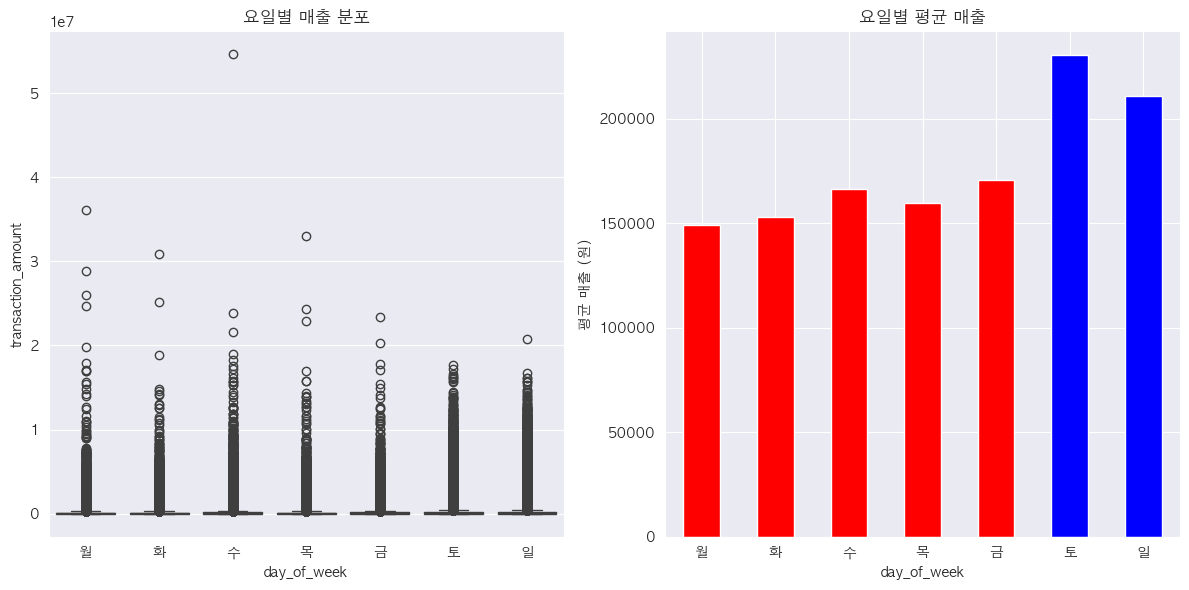

In [71]:
# 1-1. 요일별 매출 분포 박스플롯
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='day_of_week', y='transaction_amount')
plt.title('요일별 매출 분포')
plt.xticks(range(7), ['월', '화', '수', '목', '금', '토', '일'])

# 1-2. 요일별 평균 매출 막대그래프
plt.subplot(1, 2, 2)
daily_avg = df.groupby('day_of_week')['transaction_amount'].mean()
daily_avg.plot(kind='bar', color=['red' if i < 5 else 'blue' for i in range(7)])
plt.title('요일별 평균 매출')
plt.xticks(range(7), ['월', '화', '수', '목', '금', '토', '일'], rotation=0)
plt.ylabel('평균 매출 (원)')
plt.tight_layout()
plt.show()

In [80]:
daily_median = df.groupby('day_of_week')['transaction_amount'].median()
daily_mean = df.groupby('day_of_week')['transaction_amount'].mean()

print("평균 vs 중앙값 비교:")
for day in range(1, 8):
    mean_val = daily_mean[day]
    median_val = daily_median[day]
    diff_pct = (mean_val - median_val) / median_val * 100
    print(f"요일{day}: 평균 {mean_val:,.0f}원, 중앙값 {median_val:,.0f}원 (차이: {diff_pct:.1f}%)")

# 2변동계수
daily_cv = df.groupby('day_of_week')['transaction_amount'].agg(['mean', 'std'])
daily_cv['cv'] = daily_cv['std'] / daily_cv['mean']
print(f"\n변동계수 (낮을수록 안정적):")
print(daily_cv['cv'].sort_values())

평균 vs 중앙값 비교:
요일1: 평균 149,324원, 중앙값 46,414원 (차이: 221.7%)
요일2: 평균 152,953원, 중앙값 48,032원 (차이: 218.4%)
요일3: 평균 166,518원, 중앙값 50,063원 (차이: 232.6%)
요일4: 평균 159,682원, 중앙값 49,110원 (차이: 225.1%)
요일5: 평균 170,926원, 중앙값 53,159원 (차이: 221.5%)
요일6: 평균 230,450원, 중앙값 63,406원 (차이: 263.5%)
요일7: 평균 210,960원, 중앙값 56,300원 (차이: 274.7%)

변동계수 (낮을수록 안정적):
day_of_week
5    2.310963
2    2.377642
4    2.459321
1    2.524563
6    2.565692
3    2.687081
7    2.736050
Name: cv, dtype: float64
